In [1]:
import functools
import jax
import os
import html

from datetime import datetime
from jax import numpy as jp
import matplotlib.pyplot as plt

from IPython.display import HTML, clear_output, display

import flax
from brax import envs
from brax.io import model
from brax.io import json
from brax.io import html

# from src.pods.Pods import train
from src.hds.Hds import train
from src.env.Pendulum import InvertedPendulum
import pickle


In [2]:
from jax.lib import xla_bridge
print(xla_bridge.get_backend().platform)
print(jax.devices())

gpu
[cuda(id=0)]


In [3]:
env = InvertedPendulum(target=jp.array([1]))
state = jax.jit(env.reset)(rng=jax.random.PRNGKey(seed=0))

#HTML(html.render(env.sys, [state.pipeline_state]))

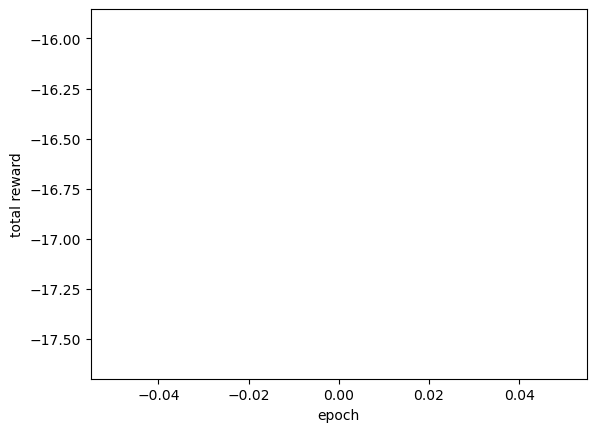

KeyboardInterrupt: 

In [4]:

def progress_f(x_data,y_data,epoch,reward):
    print(reward)
    x_data.append(epoch)
    y_data.append(reward)
    clear_output(wait=True)
    plt.xlabel('epoch')
    plt.ylabel('total reward')
    plt.plot(x_data, y_data)
    plt.show()

policy = train(env,trajectory_length=10 ,num_samples=16,epochs=100, inner_epochs=20, alpha_a=5e-4, init_learning_rate=1e-3, progress_fn=progress_f)
# policy = train(env,trajectory_length=50 ,num_samples=16,epochs=20, alpha_a=2e-5, progress_fn=progress_f)

In [ ]:
f = open("reward.txt", "w")
g = open("actions.txt", "w")
inference_fn = policy()
rollout = []
rng = jax.random.PRNGKey(seed=1)
state = env.reset(rng=rng)
reward = []
actions = []
for _ in range(1000):
  rollout.append(state.pipeline_state)
  act_rng, rng = jax.random.split(rng)
  #print(state.obs)
  act = inference_fn(state.obs)
  print(act)
  reward.append(state.reward)
  state = env.step(state, act)
  #print(state.reward)
  actions.append(act)

  
print(reward, file=f)
print(actions, file=g)

[0.06471996]
[0.05208574]
[0.05537058]
[0.06268316]
[0.07267199]
[0.08575789]
[0.10381147]
[0.12910452]
[0.16269597]
[0.20436367]
[0.25476778]
[0.31210548]
[0.36775726]
[0.41593435]
[0.44992512]
[0.46630454]
[0.4672681]
[0.46575463]
[0.4673762]
[0.47409722]
[0.48559785]
[0.5031838]
[0.52575314]
[0.5449434]
[0.5494457]
[0.52337277]
[0.4635834]
[0.4025392]
[0.2257689]
[0.06606678]
[-0.00336922]
[-0.09926277]
[-0.23857911]
[-0.35841992]
[-0.42154682]
[-0.49932927]
[-0.5960385]
[-0.66152704]
[-0.68826646]
[-0.69470817]
[-0.6827005]
[-0.65211195]
[-0.60563904]
[-0.5604765]
[-0.5293209]
[-0.48491168]
[-0.4291189]
[-0.3620555]
[-0.30368924]
[-0.26158047]
[-0.2232329]
[-0.20335686]
[-0.19099805]
[-0.18332715]
[-0.17799325]
[-0.17369148]
[-0.17325386]
[-0.17050597]
[-0.16407904]
[-0.15484065]
[-0.14520016]
[-0.13500722]
[-0.12421894]
[-0.11286725]
[-0.10103362]
[-0.08882998]
[-0.07638332]
[-0.06382544]
[-0.04901896]
[-0.03535129]
[-0.02286574]
[-0.01092577]
[0.00048817]
[0.01136273]
[0.02166571

In [ ]:

yes=html.render(env.sys.replace(dt=env.dt), rollout)
with open("data.html", "w") as file:
    file.write(yes)